匯入必要內容

In [333]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # For Isolation Forest
from sklearn.metrics import precision_recall_curve,accuracy_score, precision_score, recall_score, f1_score, classification_report
import kagglehub
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3


匯入dataset 準備data

In [334]:

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

特徵/目標分離與格式轉換

In [335]:
# --- 分離 ---
X_df = data.drop(columns=['Class'])
Y_series = data['Class']
# --- 轉換格式 ---
X = X_df.to_numpy()
Y = Y_series.to_numpy()


調整參數

In [ ]:
iso_forest__n_estimators = 200
iso_forest__contamination = 0.0017

xgb__n_estimators = 200
xgb__max_depth = 6
xgb__learning_rate = 0.1
xgb__eval_metric = 'aucpr'
xgb__min_child_weight = 5
xgb__gamma = 0.5
xgb__colsample_bytree = 1.0
xgb__subsample = 0.6
xgb__alpha = 0.1
scale_pos_weight_val_fixed = 3

pca__n_components = 12

評估函式

In [363]:

def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


In [443]:
# --- 訓練集/測試集切分 ---
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# --- 特徵標準化 ---
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# --- Isolation Forest 特徵 ---
iso_forest = IsolationForest(
    n_estimators=iso_forest__n_estimators,
    contamination=iso_forest__contamination,
    random_state=RANDOM_SEED,
)
iso_forest.fit(X_train_std)
train_anomaly_scores = iso_forest.decision_function(X_train_std).reshape(-1, 1)
test_anomaly_scores = iso_forest.decision_function(X_test_std).reshape(-1, 1)

# --- PCA 特徵 ---
pca = PCA(n_components=pca__n_components, random_state=RANDOM_SEED)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# --- 合併特徵 ---
X_train_upgrade = np.hstack((X_train_std, train_anomaly_scores, X_train_pca))
X_test_upgrade = np.hstack((X_test_std, test_anomaly_scores, X_test_pca))

# --- 訓練 XGBoost 模型 ---
xgb_model_upgrade = XGBClassifier(
    n_estimators=xgb__n_estimators,
    max_depth=xgb__max_depth,
    learning_rate=xgb__learning_rate,
    colsample_bytree=xgb__colsample_bytree,
    subsample=xgb__subsample,
    objective='binary:logistic',
    eval_metric=xgb__eval_metric,
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_val_fixed,
    random_state=RANDOM_SEED,
    tree_method='hist',
)
xgb_model_upgrade.fit(X_train_upgrade, y_train)

# --- 預測機率 ---
y_prob_upgrade = xgb_model_upgrade.predict_proba(X_test_upgrade)[:, 1]

# --- 閾值最佳化 (方法 1: 最大化 F1-score) ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob_upgrade)

fscore_values = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
fscore_values = np.nan_to_num(fscore_values)

ix_f1 = np.argmax(fscore_values)
best_threshold_f1 = pr_thresholds[ix_f1]
print(f"Best Threshold for F1-score: {best_threshold_f1:.4f} (F1: {fscore_values[ix_f1]:.4f})")
OPTIMIZED_THRESHOLD = best_threshold_f1


y_prob_upgrade = xgb_model_upgrade.predict_proba(X_test_upgrade)[:, 1]
y_pred_upgrade = (y_prob_upgrade > OPTIMIZED_THRESHOLD).astype(int)
evaluation(y_test, y_pred_upgrade, model_name="Hybrid")


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [16:59:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Threshold for F1-score: 0.1940 (F1: 0.9091)

Hybrid Evaluation:
         Accuracy: 0.9997074072773662
  Precision Score: 0.937007874015748
     Recall Score: 0.875
         F1 Score: 0.9049429657794676

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.88      0.90       136

    accuracy                           1.00     85443
   macro avg       0.97      0.94      0.95     85443
weighted avg       1.00      1.00      1.00     85443



混和矩陣

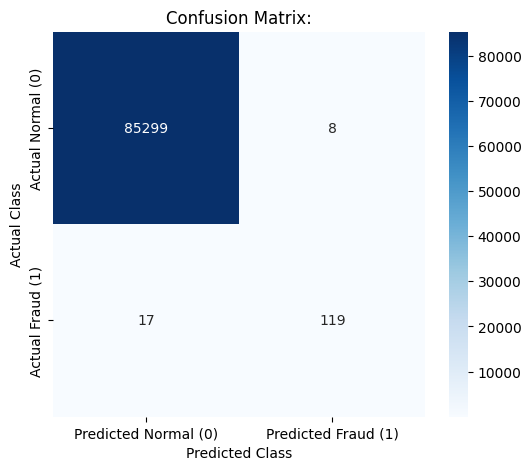

In [444]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_upgrade) # 使用 y_pred_upgrade
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal (0)', 'Predicted Fraud (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Fraud (1)'])
plt.title(f'Confusion Matrix:')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()